# Microservice and monolith performance analysis

In [440]:
import gzip
import pandas as pd
import numpy as np
from io import StringIO
from matplotlib import pyplot as plt

def readData(filename):
    with gzip.open(filename, 'rb') as f:
        content = f.read().decode('utf-8')
    df = pd.read_csv(StringIO(content), low_memory=False)
    return df

def getDurations(df):
    values = []
    timestamp = []
    start_time = df['timestamp'].iloc[0] * 1000 if df['timestamp'].iloc[0] < 1e12 else df['timestamp'].iloc[0]
    prev_timestamp = 0
    
    for index, row in df.iterrows():
        if(row['metric_name'] == "http_req_duration" and row['timestamp'] != prev_timestamp):
            current_timestamp = row['timestamp'] * 1000 if row['timestamp'] < 1e12 else row['timestamp']
            values.append(row['metric_value'])
            timestamp.append((current_timestamp - start_time)/1000)
            prev_timestamp = row['timestamp']
            
    return values, timestamp

def compare(mono, micro, y_low, y_high):
    plt.plot(mono[1], mono[0], label='Monolith', color='blue', linestyle='-')
    plt.plot(micro[1], micro[0], label='Microservice', color='red', linestyle='-')
    plt.ylabel("Latency (ms)")
    plt.xlabel("Time (s)")
    plt.ylim(y_low, y_high)
    plt.grid(True)
    plt.legend()
    plt.show()
    
def compare_req_rate(mono, micro, y_low, y_high):
    plt.plot(mono[1], mono[0], label='Monolith', color='blue', linestyle='-')
    plt.plot(micro[1], micro[0], label='Microservice', color='red', linestyle='-')
    plt.ylabel("Request rate (RPS)")
    plt.xlabel("Time (s)")
    plt.ylim(y_low, y_high)
    plt.grid(True)
    plt.legend()
    plt.show()
    
def findSampleMedian(collection):
    medians = []
    for i in range(len(collection)):
        medians.append(np.median(getDurations(collection[i])[0]))
    
    median = np.median(medians)
    median = sorted(medians)[int(len(medians)/2)]
    index = medians.index(median)
    return collection[index]

def findSampleMean(collection):
    averages = []
    for i in range(len(collection)):
        averages.append(np.mean(getDurations(collection[i])[0]))
        
    median = np.median(averages)
    median = sorted(averages)[int(len(averages)/2)]
    index = averages.index(median)
    return collection[index]

def soft(values, sec, duration=300):
    data, timestamps = values
    mean_dur = []
    mean_time = []
    start_time = timestamps[0]
    end_time = timestamps[-1]
    current_time = start_time
    
    while current_time <= end_time and current_time - start_time <= duration:
        start_index = np.searchsorted(timestamps, current_time, side='left')
        end_index = np.searchsorted(timestamps, current_time + sec, side='right')
        
        if start_index < end_index:
            mean_val = np.mean(data[start_index:end_index])
            mean_dur.append(mean_val)
            mean_time.append(current_time)

        current_time += sec
        
    return mean_dur, mean_time

def reqRate(sample):
    count = 1
    current_timestamp = 0
    rate_at_time = [[], []]
    
    for index, row in sample.iterrows():
        if row['metric_name'] == 'http_reqs':
            timestamp = row['timestamp'] - sample['timestamp'][0]
            
            if current_timestamp is None:
                current_timestamp = timestamp
            if timestamp == current_timestamp:
                count += 1
            else:
                rate_at_time[0].append(count)
                rate_at_time[1].append(current_timestamp)
                count = 1
                current_timestamp = row['timestamp'] - sample['timestamp'][0]
                
    if count > 0:
        rate_at_time[0].append(count)
        rate_at_time[1].append(current_timestamp)
        
    return rate_at_time

def median_req_rate(rates):
    req_rates = []
    
    for i in range(len(rates)):
        req_rates.append( [sum(reqRate(rates[i])[0])/reqRate(rates[i])[1][-1], rates[i]]  )
                   
    mono_ramp = sorted(mono_rates, key=lambda x: x[0])[int(len(mono_rates)/2)]
    return mono_ramp

### Reading the data
Storing the data from load tests for monolith and microservice architecture in lists. Each test was run five times to ensure reliable results

In [442]:
# Monolith baseline
#mono_baseline_1 = readData('baseline/mono_1_baseline_1.gz')
mono_baseline_2 = readData('baseline/mono_1_baseline_2.gz')
#mono_baseline_3 = readData('baseline/mono_1_baseline_3.gz')
#mono_baseline_4 = readData('baseline/mono_1_baseline_4.gz')
mono_baseline_5 = readData('baseline/mono_1_baseline_5.gz')

mono_baseline_1 = pd.read_csv('baseline/mono_2_baseline_1.csv')
#mono_baseline_2 = readData('baseline/mono_2_baseline_2.gz')
mono_baseline_3 = pd.read_csv('baseline/mono_2_baseline_3.csv')
mono_baseline_4 = pd.read_csv('baseline/mono_2_baseline_4.csv')
#mono_baseline_5 = readData('baseline/mono_2_baseline_5.gz')

#mono_baseline_1 = pd.read_csv('baseline/mono_3_baseline_1.csv')
#mono_baseline_2 = pd.read_csv('baseline/mono_3_baseline_2.csv')
#mono_baseline_3 = pd.read_csv('baseline/mono_3_baseline_3.csv')
#mono_baseline_4 = pd.read_csv('baseline/mono_3_baseline_4.csv')
#mono_baseline_5 = pd.read_csv('baseline/mono_3_baseline_5.csv')
mono_baseline_list = [mono_baseline_1, mono_baseline_2, mono_baseline_3, mono_baseline_4, mono_baseline_5]

# Microservice baseline
micro_baseline_1 = readData('baseline/micro_1_baseline_1.gz')
micro_baseline_2 = readData('baseline/micro_1_baseline_2.gz')
micro_baseline_3 = readData('baseline/micro_1_baseline_3.gz')
micro_baseline_4 = readData('baseline/micro_1_baseline_4.gz')
micro_baseline_5 = readData('baseline/micro_1_baseline_5.gz')

#micro_baseline_1 = pd.read_csv('baseline/micro_2_baseline_1.csv')
#micro_baseline_2 = pd.read_csv('baseline/micro_2_baseline_2.csv')
#micro_baseline_3 = pd.read_csv('baseline/micro_2_baseline_3.csv')
#micro_baseline_4 = pd.read_csv('baseline/micro_2_baseline_4.csv')
#micro_baseline_5 = pd.read_csv('baseline/micro_2_baseline_5.csv')
micro_baseline_list = [micro_baseline_1, micro_baseline_2, micro_baseline_3, micro_baseline_4, micro_baseline_5]

# Monolith ramp
mono_ramp_1 = pd.read_csv('ramp/mono_1_ramp_1.csv')
mono_ramp_2 = pd.read_csv('ramp/mono_1_ramp_2.csv')
mono_ramp_3 = pd.read_csv('ramp/mono_1_ramp_3.csv')
mono_ramp_4 = pd.read_csv('ramp/mono_1_ramp_4.csv')
mono_ramp_5 = pd.read_csv('ramp/mono_1_ramp_5.csv')
mono_ramp_list = [mono_ramp_1, mono_ramp_2, mono_ramp_3, mono_ramp_4, mono_ramp_5]

# Microservice ramp
micro_ramp_1 = pd.read_csv('ramp/micro_1_ramp_1.csv')
micro_ramp_2 = pd.read_csv('ramp/micro_1_ramp_2.csv')
micro_ramp_3 = pd.read_csv('ramp/micro_1_ramp_3.csv')
micro_ramp_4 = pd.read_csv('ramp/micro_1_ramp_4.csv')
micro_ramp_5 = pd.read_csv('ramp/micro_1_ramp_5.csv')
micro_ramp_list = [micro_ramp_1, micro_ramp_2, micro_ramp_3, micro_ramp_4, micro_ramp_5]

# Monolith scale
mono_scal_2c4g_1 = readData('scale/mono_2C-4G_ramp_1.csv.gz')
mono_scal_2c4g_2 = readData('scale/mono_2C-4G_ramp_2.csv.gz')
mono_scal_2c4g_3 = readData('scale/mono_2C-4G_ramp_3.csv.gz')
mono_scal_2c4g_4 = readData('scale/mono_2C-4G_ramp_4.csv.gz')
#mono_scal_2c4g_5 = readData('scale/mono_2C-4G_ramp_5.csv.gz')
#mono_2c4g_list = [mono_scal_2c4g_1, mono_scal_2c4g_2, mono_scal_2c4g_3, mono_scal_2c4g_4, mono_scal_2c4g_5]

mono_scal_4c8g_1 = readData('scale/mono_4C-8G_ramp_1.csv.gz')
mono_scal_4c8g_2 = readData('scale/mono_4C-8G_ramp_2.csv.gz')
mono_scal_4c8g_3 = readData('scale/mono_4C-8G_ramp_3.csv.gz')
mono_scal_4c8g_4 = readData('scale/mono_4C-8G_ramp_4.csv.gz')
mono_scal_4c8g_5 = readData('scale/mono_4C-8G_ramp_5.csv.gz')
mono_4c8g_list = [mono_scal_4c8g_1, mono_scal_4c8g_2, mono_scal_4c8g_3, mono_scal_4c8g_4, mono_scal_4c8g_5]

# Microservice scale
micro_scal_2c4g_1 = readData('scale/micro_2C-4G_ramp_1.csv.gz')
micro_scal_2c4g_2 = readData('scale/micro_2C-4G_ramp_2.csv.gz')
micro_scal_2c4g_3 = readData('scale/micro_2C-4G_ramp_3.csv.gz')
micro_scal_2c4g_4 = readData('scale/micro_2C-4G_ramp_4.csv.gz')
micro_scal_2c4g_5 = readData('scale/micro_2C-4G_ramp_5.csv.gz')
micro_2c4g_list = [micro_scal_2c4g_1, micro_scal_2c4g_2, micro_scal_2c4g_3, micro_scal_2c4g_4, micro_scal_2c4g_5]

#micro_scal_4c8g_1 = 

### Plotting graphs comparing the performance of the architectures
Of the five tests that were done for each case, the median/mean performing test is used in the plot

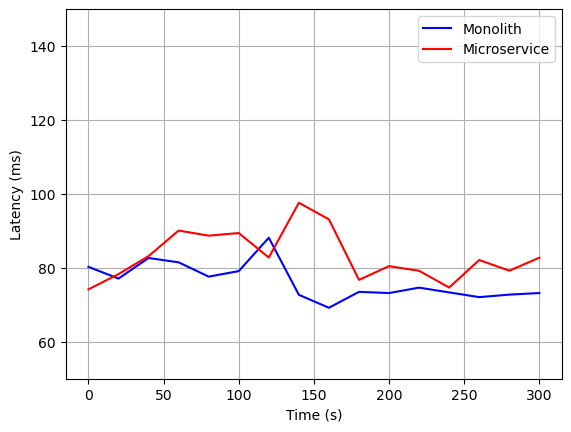

In [439]:
# Compare baseline results

mono_baseline_true = getDurations(findSampleMedian(mono_baseline_list))
micro_baseline_true = getDurations(findSampleMedian(micro_baseline_list))

mono_baseline_10sec = soft(mono_baseline_true, 20)
micro_baseline_10sec = soft(micro_baseline_true, 20)

compare(mono_baseline_10sec, micro_baseline_10sec, 50, 150)

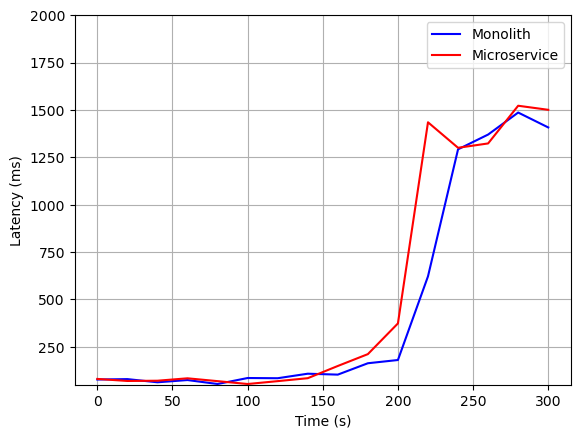

In [443]:
# Compare ramp test results

#mono_ramp_true = getDurations(median_req_rate(mono_ramp_list))
#micro_ramp_true = getDurations(median_req_rate(micro_ramp_list))

mono_ramp_true = getDurations(findSampleMean(mono_ramp_list))
micro_ramp_true = getDurations(findSampleMean(micro_ramp_list))

mono_ramp_10sec = soft(mono_ramp_true, 20)
micro_ramp_10sec = soft(micro_ramp_true, 20)

compare(mono_ramp_10sec, micro_ramp_10sec, 50, 2000)

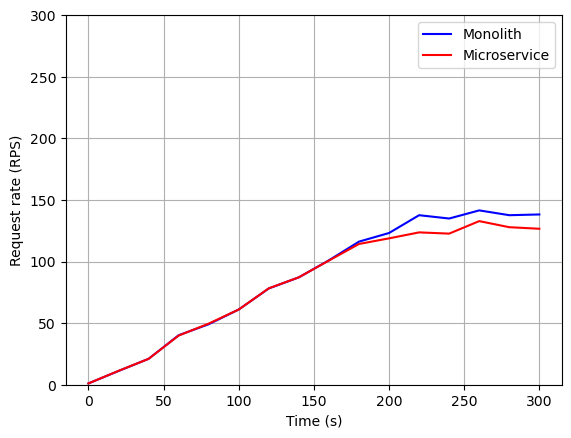

In [231]:
# Compare request rates in ramp test
compare_req_rate(soft(reqRate(findSampleMean(mono_ramp_list)), 20),
                 soft(reqRate(findSampleMean(micro_ramp_list)), 20), y_low=0, y_high=300)

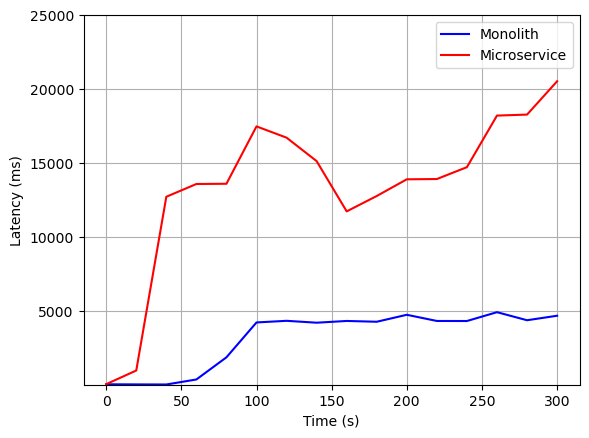

In [444]:
# Compare architectures with 2 cores and 4 GB

mono_2c4g_true = getDurations(findSampleMean(mono_2c4g_list))
micro_2c4g_true = getDurations(findSampleMean(micro_2c4g_list))

mono_2c4g_10sec = soft(mono_2c4g_true, 20)
micro_2c4g_10sec = soft(micro_2c4g_true, 20)

compare(mono_2c4g_10sec, micro_2c4g_10sec, 50, 25000)

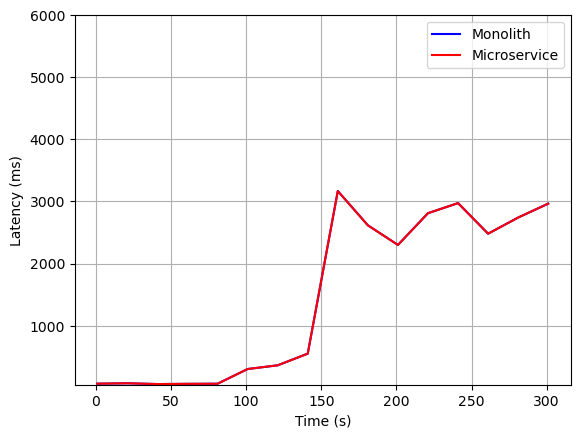

In [334]:
# Compare architectures with 4 cores and 8 GB

mono_4c8g_true = getDurations(findSampleMean(mono_4c8g_list))
#micro_4c8g_true = getDurations(findSampleMean(micro_4c8g_list))

mono_4c8g_10sec = soft(mono_4c8g_true, 20)
#micro_4c8g_10sec = soft(micro_4c8g_true, 20)

compare(mono_4c8g_10sec, mono_4c8g_10sec, 50, 6000)

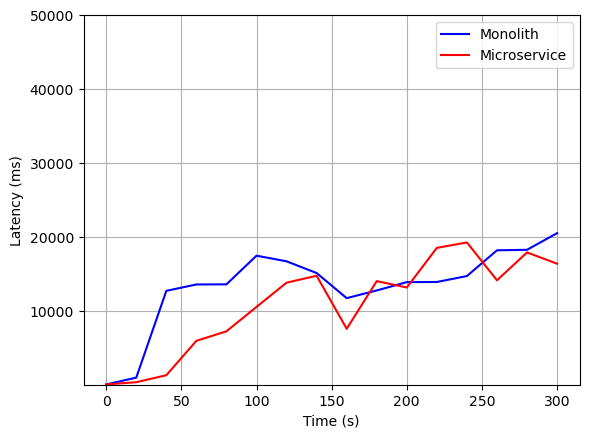

In [333]:
compare(soft(getDurations(micro_scal_2c4g_5), 20),
        soft(getDurations(micro_scal_2c4g_4), 20), 50, 50000)

In [359]:
# Printing average latency for monolith and microservice
# print("Monolith:", findSampleMean(mono_baseline_list[1:5]))
# print("Microservice: ", findSampleMean(micro_baseline_list[1:5]))